# CNN + Synthetic Minority Oversampling Technique (SMOTE)

# Introduction
In this notebook, we will use the same model from CNN.ipynb but with SMOTE method for data preprocessing step for over-sampling. SMOTE is a technique to generate data that has similarity with data in minority class: each time SMOTE generate new data, it picks two data vectors in a minority class and generate data vector between the two vectors in the feature space.

In [2]:
from datasets import load_dataset
import random
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tokenizers import Tokenizer, models, trainers
from tokenizers.pre_tokenizers import Whitespace
import torch.nn as nn
import torch
from sklearn.preprocessing import LabelEncoder
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [41]:
emotions = load_dataset("dair-ai/emotion")

In [3]:
labels = ["sadness", "joy", "love", "anger", "fear", "surprise"]

In [43]:
train_data = emotions["train"]
validation_data = emotions["validation"]
test_data = emotions["test"]

In [44]:
# Tokenization
vocab_n = 5000
sequence_len = 64

# Initialize a tokenizer using BPE (Byte Pair Encoding)
tokenizer = Tokenizer(models.BPE())
tokenizer.pre_tokenizer = Whitespace()
tokenizer.enable_padding(length=sequence_len)
tokenizer.enable_truncation(max_length=sequence_len)
tokenizer_trainer = trainers.BpeTrainer(vocab_size=vocab_n)
tokenizer.train_from_iterator(train_data["text"], trainer=tokenizer_trainer)

# SMOTE
Apply SMOTE for tokenized training data, printing the shape of resampled label list to check if the SMOTE is successful. We can observe that every class now have same quantity of training data.

In [ ]:
# Encode train text to token IDs
encoded_train = [tokenizer.encode(text).ids for text in train_data["text"]]

# Pad sequences manually to the same length (e.g., max length in dataset)
max_len = max(len(seq) for seq in encoded_train)
X_padded = np.array([seq + [0] * (max_len - len(seq)) for seq in encoded_train])

# Encode labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(train_data["label"])

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_padded, y_encoded)

# For training, convert y_resampled back to tensor
X_resampled = torch.tensor(X_resampled, dtype=torch.long)
y_resampled = torch.tensor(y_resampled, dtype=torch.long)

print("After SMOTE:", dict(zip(*np.unique(y_resampled.numpy(), return_counts=True))))


After SMOTE: {np.int64(0): np.int64(5362), np.int64(1): np.int64(5362), np.int64(2): np.int64(5362), np.int64(3): np.int64(5362), np.int64(4): np.int64(5362), np.int64(5): np.int64(5362)}


Add process_SMOTE for preprocessing training data, because training data has already been tokenized in steps above.

In [46]:
def preprocess_text(text: str, tokenizer: Tokenizer):
    """ 
    Helper function to tokenize text and return corresponding token IDs as tensors.

    Args:
        text, str: Text instance from training data.
        tokenizer, Tokenizer: The respective tokenizer to be used for tokenization.
    Returns:
        Tensor: One-dimensional PyTorch tensor with token IDs.
    """
    return torch.tensor(tokenizer.encode(text).ids)


def preprocess_label(label: int):
    """ 
    Helper function to return label as tensor.

    Args:
        label, int: Label from instance.
    Returns:
        Tensor: One-dimensional PyTorch tensor containing the label index.
    """
    return torch.tensor(label)


def preprocess(data: dict, tokenizer: Tokenizer):
    """ 
    Transforms input dataset to tokenized vector representations.

    Args:
        data, dict: Dictionary with text instances and labels.
        tokenizer, Tokenizer: The respective tokenizer to be used for tokenization.
    Returns:
        list: List with tensors for the input texts and labels.
    """
    instances = []

    for text, label in zip(data["text"], data["label"]):
        input = preprocess_text(text, tokenizer)
        label = preprocess_label(label)
        
        instances.append((input, label))

    return instances

def preprocess_SMOTE(x, y):
    """ 
    Zip input tokenized dataset for training.

    Returns:
        list: List with tensors for the input texts and labels.
    """
    instances = []

    for text, label in zip(x, y):
        instances.append((text, label))

    return instances

In [47]:
train_instances = preprocess_SMOTE(X_resampled, y_resampled)
val_instances = preprocess(validation_data, tokenizer)
test_instances = preprocess(test_data, tokenizer)

In [48]:
# Batching

def batching(instances: list, batch_size: int, shuffle: bool):
    """ 
    Batches input instances along the given size and returns list of batches.

    Args:
        instances, list: List of instances, containing a tuple of two tensors 
            for each text as well as corresponding label.
        batch_size, int: Size for batches.
        shuffle, bool: If true, the instances will be shuffled before batching.
    Returns:
        list: List containing tuples that correspond to single batches.
    """
    if shuffle:
        random.shuffle(instances)

    batches = []

    # We iterate through the instances with batch_size steps
    for i in range(0, len(instances), batch_size):

        # Stacking the instances with dim=0 (default value)
        batch_texts = torch.stack(
            [instance[0] for instance in instances[i : i + batch_size]]
        )
        batch_labels = torch.stack(
            [instance[1] for instance in instances[i : i + batch_size]]
        )

        batches.append((batch_texts, batch_labels))
    
    return batches

In [49]:
# CNN Network

class CNN_Classifier(nn.Module):
    """ 
    CNN for sentiment classification with 6 classes, consisting of an embedding 
    layer, two convolutional layers with different filter sizes, different 
    pooling sizes, as well as one linear output layer.
    """
    def __init__(self):
        super().__init__()
        # We can implement embeddings as a simple lookup-table for given word 
        # indices
        self.embedding = nn.Embedding(tokenizer.get_vocab_size(), 300)

        # One-dimensional convolution-layer with 300 input channels, and 100  
        # output channels as well as kernel size of 3; note that the
        # one-dimensional convolutional layer has 3 dimensions
        self.conv_1 = nn.Conv1d(300, 100, 3, padding="same")

        # Pooling with with a one-dimensional sliding window of length 3, 
        # reducing in this fashion the sequence length 
        self.pool_1 = nn.MaxPool1d(3)

        # The input will be the reduced number of maximum picks from the
        # previous operation; the dimension of those picks is the same as the
        # output channel size from self.conv_1. We apply a different filter of 
        # size 5.
        self.conv_2 = nn.Conv1d(100, 50, 5, padding="same")

        # Pooling with window size of 5
        self.pool_2 = nn.MaxPool1d(5)

        # Final fully connected linear layer from the 50 output channels to the
        # 6 sentiment categories 
        self.linear_layer = nn.Linear(50, 6)

    def forward(self, x):
        """ 
        Defining the forward pass of an input batch x.

        Args:
            x, tensor: The input is a batch of tweets from the data.
        Returns:
            y, float: The output are the logits from the final layer.
        """
        # x will correspond here to a batch; therefore, the input dimensions of 
        # the embedding will be by PyTorch convention as follows:
        # [batch_size, seq_len, emb_dim]
        x = self.embedding(x)

        # Unfortunately the embedding tensor does not correspond to the shape 
        # that is needed for nn.Conv1d(); for this reason, we must switch its 
        # order to [batch_size, emb_dim, seq_len] for PyTorch
        x = x.permute(0, 2, 1)

        # We can wrap the ReLu activation function around our convolution layer
        # The output tensor will have the following shape: 
        # [batch_size, 100, seq_len]
        x = nn.functional.relu(self.conv_1(x))

        # Applying max pooling of size 3 means that the output length of the 
        # sequence is shrunk to seq_len//3
        x = self.pool_1(x)

        # Output of the following layer: [batch_size, 50, seq_len//3]
        x = nn.functional.relu(self.conv_2(x))

        # Shrinking the sequence length by 5
        x = self.pool_2(x)
        # print(x.shape)

        # At this point we have a tensor with 3 dimensions; however, the final layer 
        # requires an input of size [batch_size x 50]. To get this value we can 
        # aggregate the values and continue only with their mean
        x = x.mean(dim=-1)

        # In this fasion, the linear layer can be used to make predictions
        y = self.linear_layer(x)

        return y
    
    def fit(self, train_instances, val_instances, epochs, batch_size):
        """ 
        Gradient based fitting method with Adam optimization and automatic 
        evaluation (F1 score) for each epoch.

        Args:
            train_instances, list: List of instance tuples.
            val_instances, list: List of instance tuples.
            epochs, int: Number of training epochs.
            batch_size, int: Number of batch size.
        """
        self.train()
        optimizer = torch.optim.Adam(self.parameters())

        for epoch in range(epochs):
            train_batches = batching(
                train_instances,
                batch_size=batch_size,
                shuffle=True)
            
            for inputs, labels in tqdm(train_batches):
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = nn.functional.cross_entropy(outputs, labels)
                loss.backward()
                optimizer.step()
            
            train_f1 = self.evaluate2(train_instances, batch_size=batch_size)
            val_f1 = self.evaluate2(val_instances, batch_size=batch_size)

            print(f"Epoch {epoch + 1} train F1 score: {train_f1}, validation F1 score: {val_f1}")

    def predict(self, input):
        """ 
        To make inferences from the model.

        Args:
            input, tensor: Single instance.
        Returns:
            int: Integer for most probable class.
        """
        self.eval()
        outputs = self(input)

        return torch.argmax(outputs, dim=-1)

    def evaluate(self, instances, batch_size):
        """ 
        To evaluate model's performance by various processes/standard.

        Args:
            instances, list: List of instance tuples.
            batch_size, int: Batch size.
        Returns:
            float: Macro F1 score for given instances.
        """
        batches = batching(instances, batch_size=batch_size, shuffle=False)
        y_test = []
        y_pred = []

        for inputs, labels in batches:
            y_test.extend(labels)
            y_pred.extend(self.predict(inputs))

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')
        cm = confusion_matrix(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        print("CNN Classifier:")
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1 Score: {f1}")
        print(f"Confusion Matrix:\n{cm}")
        print(f"Classification Report:\n{report}")

    def evaluate2(self, instances, batch_size):
        """ 
        To make evaluations against the gold standard (true labels) from the 
        data.

        Args:
            instances, list: List of instance tuples.
            batch_size, int: Batch size.
        Returns:
            float: Macro F1 score for given instances.
        """
        batches = batching(instances, batch_size=batch_size, shuffle=False)
        true = []
        pred = []

        for inputs, labels in batches:
            true.extend(labels)
            pred.extend(self.predict(inputs))

        return f1_score(true, pred, average="macro")

In [50]:
classifier = CNN_Classifier()
classifier.fit(train_instances, val_instances, epochs=50, batch_size=16)

100%|██████████| 2011/2011 [00:07<00:00, 256.07it/s]


Epoch 1 train F1 score: 0.5474926717600233, validation F1 score: 0.6166991467329813


100%|██████████| 2011/2011 [00:07<00:00, 253.86it/s]


Epoch 2 train F1 score: 0.6375881659547775, validation F1 score: 0.8194831167616065


100%|██████████| 2011/2011 [00:07<00:00, 254.73it/s]


Epoch 3 train F1 score: 0.7090111714382941, validation F1 score: 0.8443250247843402


100%|██████████| 2011/2011 [00:07<00:00, 260.49it/s]


Epoch 4 train F1 score: 0.7485006845844745, validation F1 score: 0.8228153751028052


100%|██████████| 2011/2011 [00:07<00:00, 257.01it/s]


Epoch 5 train F1 score: 0.794434000532148, validation F1 score: 0.808864875615937


100%|██████████| 2011/2011 [00:08<00:00, 242.74it/s]


Epoch 6 train F1 score: 0.8507305198855618, validation F1 score: 0.8268384096201093


100%|██████████| 2011/2011 [00:08<00:00, 228.47it/s]


Epoch 7 train F1 score: 0.907865721020067, validation F1 score: 0.8056530791259645


100%|██████████| 2011/2011 [00:08<00:00, 237.82it/s]


Epoch 8 train F1 score: 0.9383799194777979, validation F1 score: 0.8041322824094119


100%|██████████| 2011/2011 [00:07<00:00, 256.49it/s]


Epoch 9 train F1 score: 0.9540851018937869, validation F1 score: 0.7962716282189822


100%|██████████| 2011/2011 [00:08<00:00, 243.66it/s]


Epoch 10 train F1 score: 0.9522997957688624, validation F1 score: 0.8001167403454822


100%|██████████| 2011/2011 [00:07<00:00, 254.54it/s]


Epoch 11 train F1 score: 0.9787963712652584, validation F1 score: 0.7962965807680981


100%|██████████| 2011/2011 [00:07<00:00, 256.14it/s]


Epoch 12 train F1 score: 0.9823830953666596, validation F1 score: 0.7958236795399883


100%|██████████| 2011/2011 [00:08<00:00, 250.70it/s]


Epoch 13 train F1 score: 0.9808493032672999, validation F1 score: 0.7926190395132697


100%|██████████| 2011/2011 [00:07<00:00, 254.98it/s]


Epoch 14 train F1 score: 0.9861788706414968, validation F1 score: 0.7895546970562353


100%|██████████| 2011/2011 [00:07<00:00, 259.65it/s]


Epoch 15 train F1 score: 0.9821292882136449, validation F1 score: 0.7807861098922092


100%|██████████| 2011/2011 [00:08<00:00, 250.09it/s]


Epoch 16 train F1 score: 0.988718423932886, validation F1 score: 0.7905891002720682


100%|██████████| 2011/2011 [00:07<00:00, 259.47it/s]


Epoch 17 train F1 score: 0.9890617755060703, validation F1 score: 0.8002802521969143


100%|██████████| 2011/2011 [00:07<00:00, 257.62it/s]


Epoch 18 train F1 score: 0.9893354596038447, validation F1 score: 0.803884993625713


100%|██████████| 2011/2011 [00:07<00:00, 258.48it/s]


Epoch 19 train F1 score: 0.9886697817452911, validation F1 score: 0.7981515679654577


100%|██████████| 2011/2011 [00:07<00:00, 251.43it/s]


Epoch 20 train F1 score: 0.9899952812367165, validation F1 score: 0.7876379996644068


100%|██████████| 2011/2011 [00:07<00:00, 256.50it/s]


Epoch 21 train F1 score: 0.9901204326318624, validation F1 score: 0.7871445167561263


100%|██████████| 2011/2011 [00:08<00:00, 247.09it/s]


Epoch 22 train F1 score: 0.9866002357146729, validation F1 score: 0.7948767700119546


100%|██████████| 2011/2011 [00:07<00:00, 263.71it/s]


Epoch 23 train F1 score: 0.9868529894230336, validation F1 score: 0.7914699243416994


100%|██████████| 2011/2011 [00:07<00:00, 257.54it/s]


Epoch 24 train F1 score: 0.9887879184305458, validation F1 score: 0.7863440530496751


100%|██████████| 2011/2011 [00:07<00:00, 254.22it/s]


Epoch 25 train F1 score: 0.9923546195506353, validation F1 score: 0.7829991519646805


100%|██████████| 2011/2011 [00:07<00:00, 255.07it/s]


Epoch 26 train F1 score: 0.9934125113261106, validation F1 score: 0.7924738338325065


100%|██████████| 2011/2011 [00:07<00:00, 257.17it/s]


Epoch 27 train F1 score: 0.9861875653587416, validation F1 score: 0.7828203752653552


100%|██████████| 2011/2011 [00:07<00:00, 253.81it/s]


Epoch 28 train F1 score: 0.986669175316247, validation F1 score: 0.7736321399149751


100%|██████████| 2011/2011 [00:07<00:00, 258.03it/s]


Epoch 29 train F1 score: 0.9948402445945566, validation F1 score: 0.8022790461801477


100%|██████████| 2011/2011 [00:07<00:00, 252.89it/s]


Epoch 30 train F1 score: 0.9923220167562551, validation F1 score: 0.8058005813859199


100%|██████████| 2011/2011 [00:07<00:00, 256.55it/s]


Epoch 31 train F1 score: 0.9949352761982025, validation F1 score: 0.7946943555147693


100%|██████████| 2011/2011 [00:07<00:00, 256.18it/s]


Epoch 32 train F1 score: 0.9926611837732752, validation F1 score: 0.8033979253276288


100%|██████████| 2011/2011 [00:08<00:00, 250.97it/s]


Epoch 33 train F1 score: 0.9868705864373798, validation F1 score: 0.7822933989385025


100%|██████████| 2011/2011 [00:07<00:00, 255.57it/s]


Epoch 34 train F1 score: 0.9947444628563024, validation F1 score: 0.8106288569110883


100%|██████████| 2011/2011 [00:07<00:00, 255.45it/s]


Epoch 35 train F1 score: 0.9925101699840978, validation F1 score: 0.8036554900873641


100%|██████████| 2011/2011 [00:08<00:00, 244.30it/s]


Epoch 36 train F1 score: 0.9935098497573663, validation F1 score: 0.7981069012924155


100%|██████████| 2011/2011 [00:07<00:00, 252.26it/s]


Epoch 37 train F1 score: 0.9916278087887954, validation F1 score: 0.7990072165142074


100%|██████████| 2011/2011 [00:08<00:00, 247.66it/s]


Epoch 38 train F1 score: 0.9939995552568243, validation F1 score: 0.8021944061268268


100%|██████████| 2011/2011 [00:08<00:00, 239.08it/s]


Epoch 39 train F1 score: 0.9931347364807713, validation F1 score: 0.7901386238203324


100%|██████████| 2011/2011 [00:08<00:00, 224.77it/s]


Epoch 40 train F1 score: 0.9922865557896979, validation F1 score: 0.7868222893616189


100%|██████████| 2011/2011 [00:08<00:00, 242.22it/s]


Epoch 41 train F1 score: 0.9899014715450316, validation F1 score: 0.7920889557644007


100%|██████████| 2011/2011 [00:08<00:00, 250.89it/s]


Epoch 42 train F1 score: 0.995178480540373, validation F1 score: 0.8011436348969809


100%|██████████| 2011/2011 [00:08<00:00, 251.19it/s]


Epoch 43 train F1 score: 0.9936570652640109, validation F1 score: 0.8100868764243258


100%|██████████| 2011/2011 [00:08<00:00, 231.73it/s]


Epoch 44 train F1 score: 0.9952736144325617, validation F1 score: 0.7977086340456773


100%|██████████| 2011/2011 [00:08<00:00, 244.74it/s]


Epoch 45 train F1 score: 0.9951819168025229, validation F1 score: 0.785445003937352


100%|██████████| 2011/2011 [00:08<00:00, 249.03it/s]


Epoch 46 train F1 score: 0.9900443271637164, validation F1 score: 0.7977888870528554


100%|██████████| 2011/2011 [00:07<00:00, 254.23it/s]


Epoch 47 train F1 score: 0.9944043196515442, validation F1 score: 0.7951074647141398


100%|██████████| 2011/2011 [00:08<00:00, 249.82it/s]


Epoch 48 train F1 score: 0.9952430781572823, validation F1 score: 0.7850184903422752


100%|██████████| 2011/2011 [00:08<00:00, 247.02it/s]


Epoch 49 train F1 score: 0.9967675644525943, validation F1 score: 0.8014150340674858


100%|██████████| 2011/2011 [00:08<00:00, 245.85it/s]


Epoch 50 train F1 score: 0.9889398797064595, validation F1 score: 0.7890339193450738


In [51]:
f1_test = classifier.evaluate(test_instances, batch_size=16)

CNN Classifier:
Accuracy: 0.844
Precision: 0.7654078790894859
Recall: 0.7897302118523414
F1 Score: 0.7738359543953118
Confusion Matrix:
[[517  20  11  10  17   6]
 [  7 613  44   2  17  12]
 [  3  21 122   1   7   5]
 [ 20  11  13 211  18   2]
 [  8   7   3   7 185  14]
 [  1   9   2   0  14  40]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       581
           1       0.90      0.88      0.89       695
           2       0.63      0.77      0.69       159
           3       0.91      0.77      0.83       275
           4       0.72      0.83      0.77       224
           5       0.51      0.61      0.55        66

    accuracy                           0.84      2000
   macro avg       0.77      0.79      0.77      2000
weighted avg       0.86      0.84      0.85      2000



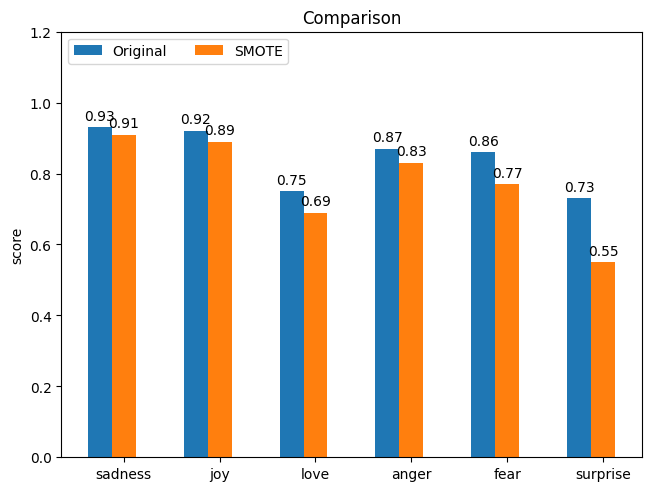

In [4]:
performance = {
    'Original': (0.93, 0.92, 0.75, 0.87, 0.86, 0.73),
    'SMOTE': (0.91, 0.89, 0.69, 0.83, 0.77, 0.55)
}

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in performance.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('score')
ax.set_title('Comparison')
ax.set_xticks(x + width, labels)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1.2)

plt.show()

# Result&Conclusion
From the result above, we can say that SMOTE does not help with our model to classify the minority class; in fact, it makes the model performs worse. The overall accuracy drops from 89% from original CNN model to 84% after applying SMOTE; the f1-score for class 5 (surprise) is only 55% comparing to 73% from original CNN model.   
After researches, we speculate that it is not a good idea to apply SMOTE for text classification task, as the generated data by SMOTE may be meaningless in text-level since this method generates data in high-dimensional token space - the generated data may make no sense if converted back to text data from the token space.